<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Infra

Change Requests:
* Remove zeros of market capitalization
* Combine with other tables that don't often update but are useful for research

In [40]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
#@title pip 
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install requests --quiet
!pip install pipreqs --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet

!pip install matplotlib --quiet
!pip install mplfinance --quiet

In [42]:
#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

(Reading database ... 124017 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

## Setup SQLite


In [44]:
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [45]:
#@title   Show Available Tables { display-mode: "code" }
cursor = conn_SQLite.cursor()

%time
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#cursor.execute("DROP TABLE 'proprietary_Twitter_Partnership_ohlc';")
cursor.fetchall()

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.4 µs


[('deFi_lama_total_TVL',),
 ('proprietary_Twitter_Partnership_ohlc',),
 ('proprietary_master_id',),
 ('CoinGecko_ohlc',),
 ('proprietary_tweets_extract',),
 ('proprietary_Twitter_partnerships_announcements',),
 ('proprietary_dashboard',),
 ('watchlist_CoinGecko_ohlc',),
 ('deFi_lama_tvl',),
 ('testing',),
 ('proprietary_airtable_watch_all',),
 ('deFi_lama_general',),
 ('proprietary_Twitter_id',),
 ('CoinGecko_main',),
 ('cal_mvp',),
 ('proprietary_economic_announcement',),
 ('ftx_subaccount_nickname',),
 ('ftx_subaccount_balances',),
 ('ftx_account',),
 ('ftx_positions',),
 ('ftx_wallet_coins',),
 ('ftx_wallet_deposits',),
 ('ftx_wallet_withdrawals',),
 ('ftx_orders_history',),
 ('ftx_fills',),
 ('ftx_funding_payments',),
 ('ftx_balancess',),
 ('ftx_markets',),
 ('ftx_futures',),
 ('CoinGecko_currencies',),
 ('CoinGecko_global',),
 ('CoinGecko_asset_platforms',),
 ('proprietary_screener s',),
 ('proprietary_screener_hist',),
 ('proprietary_screener_ohlc',),
 ('CoinGecko_derivatives',),

# Extract Data

Data source: [CoinGecko API wrapper](https://github.com/man-c/pycoingecko)

In [46]:
#@title Main – Extract { display-mode: "code" }

frames = []
cg = CoinGeckoAPI()

try:

  start =  1
  ends = 70

  for i in tqdm(range(start,ends)):

    output = cg.get_coins_markets(vs_currency='usd', page = i)
    
    data = pd.json_normalize(output,max_level=4)
    frames.append(data)
    time.sleep(10)

except ConnectionError:
    time.sleep(60)

full_table = pd.concat(frames) #Careful, this line must be outside of the for loop




  0%|          | 0/69 [00:00<?, ?it/s]

In [47]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                6900 non-null   object 
 1   symbol                            6900 non-null   object 
 2   name                              6900 non-null   object 
 3   image                             6900 non-null   object 
 4   current_price                     6900 non-null   float64
 5   market_cap                        6900 non-null   float64
 6   market_cap_rank                   3942 non-null   object 
 7   fully_diluted_valuation           3406 non-null   float64
 8   total_volume                      6900 non-null   float64
 9   high_24h                          5717 non-null   float64
 10  low_24h                           5717 non-null   float64
 11  price_change_24h                  5717 non-null   float64
 12  price_ch

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effa4fdff10>,
      dtype=object)

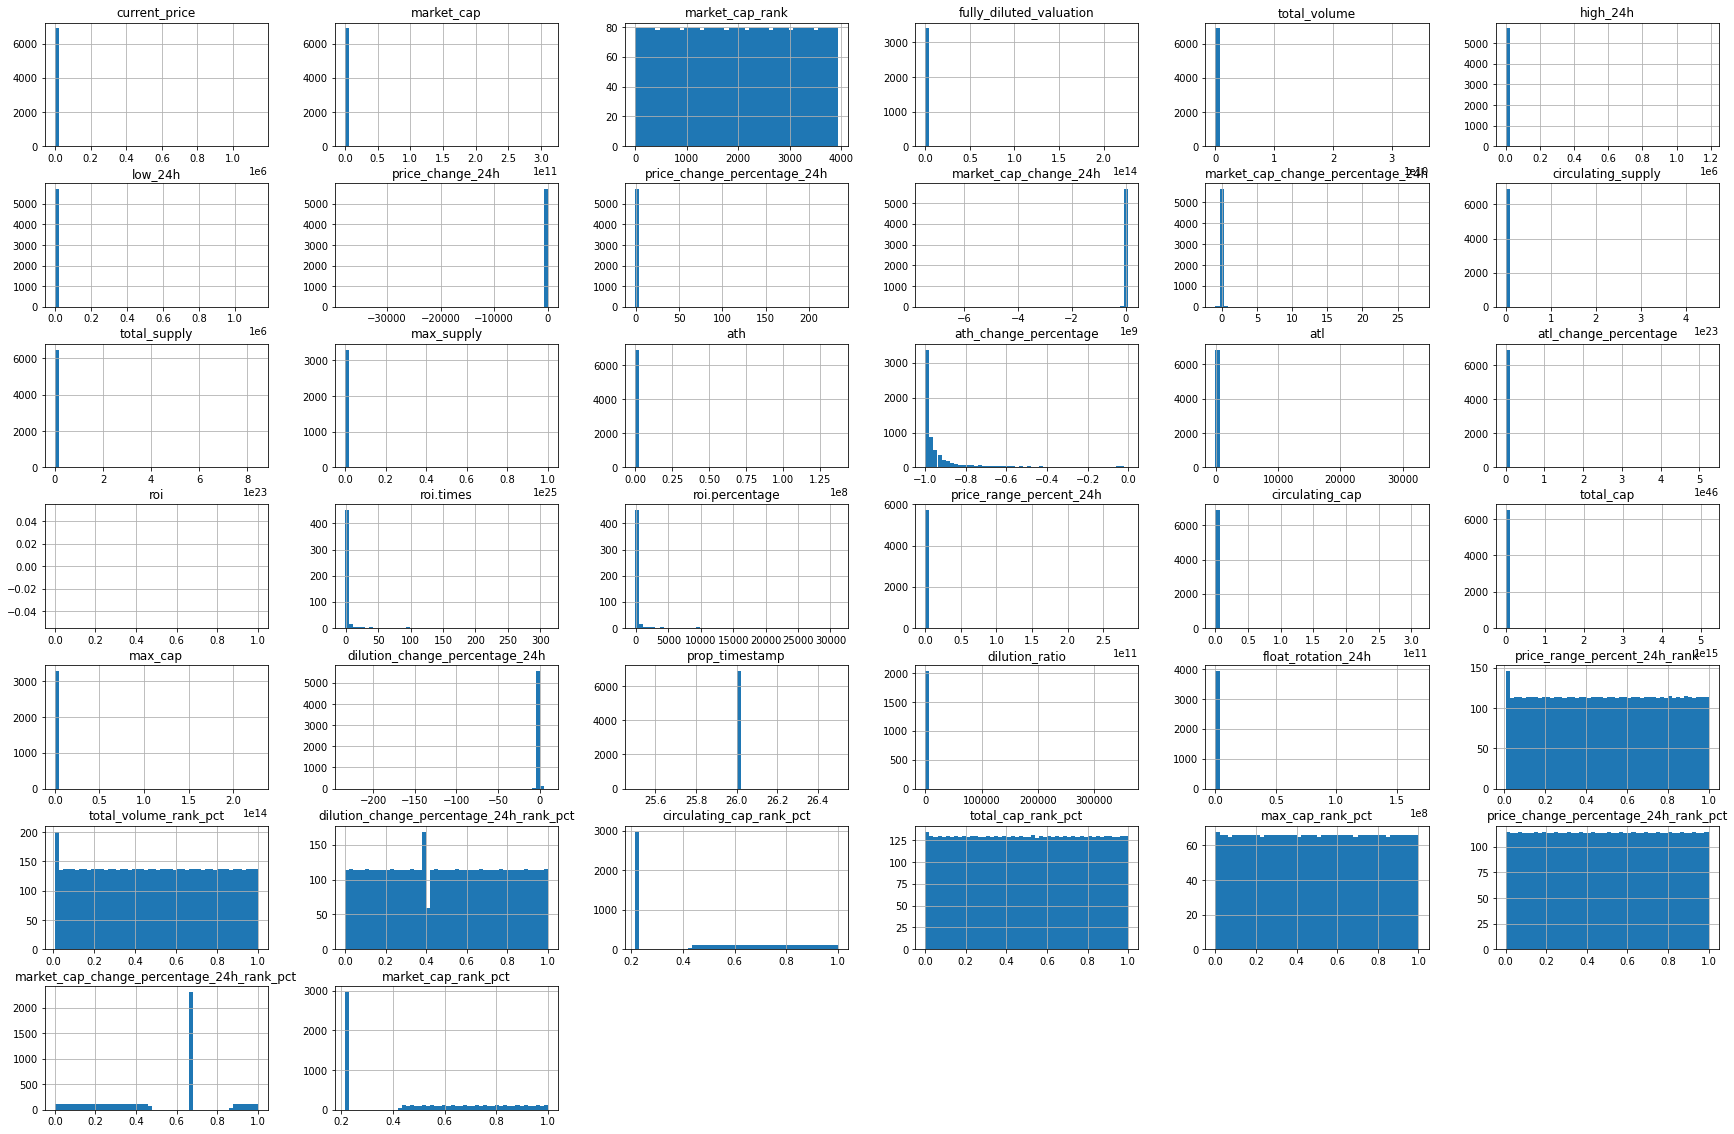

In [48]:
#0 division function
def zerodiv(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 0


#@title Main – Wrangling{ display-mode: "code" }
full_table['price_range_percent_24h'] =  (full_table['high_24h'] - full_table['low_24h'] ) / 0.5*(full_table['high_24h'] + full_table['low_24h'] ) 
full_table['circulating_cap'] = full_table['current_price'] * full_table['circulating_supply']
full_table['total_cap'] = full_table['current_price'] * full_table['total_supply']
full_table['max_cap'] = full_table['current_price'] * full_table['max_supply']
full_table['price_change_percentage_24h'] = round(full_table['price_change_percentage_24h'], 5)/100
full_table['ath_change_percentage'] = full_table['ath_change_percentage']/100
full_table['market_cap_change_percentage_24h'] = full_table['market_cap_change_percentage_24h']/100
full_table['atl_change_percentage'] = full_table['atl_change_percentage']/100
full_table['dilution_change_percentage_24h'] = full_table['market_cap_change_percentage_24h'] - full_table['price_change_percentage_24h']
full_table['prop_timestamp'] = int( time.time_ns() / 1000 )
full_table['prop_timestamp'] = full_table['prop_timestamp'].astype(np.int8)
full_table['CoinGecko_link'] = str('https://www.coingecko.com/en/coins/') + full_table['id']
full_table['symbol'] = full_table['symbol'].str.upper()
full_table['dilution_ratio'] = zerodiv(full_table['max_supply'],full_table['circulating_supply'])
        
#full_table['dilution_ratio'] = full_table['max_supply'] / full_table['circulating_supply']
full_table['float_rotation_24h'] = zerodiv(full_table['total_volume'],full_table['market_cap'])
full_table['price_change_percentage_24h']  = full_table['price_change_percentage_24h']

#Ranking
full_table['price_range_percent_24h_rank']  =  full_table['price_range_percent_24h'].rank(pct=True)
full_table['total_volume_rank_pct']  =  full_table['total_volume'].rank(pct=True)
full_table['dilution_change_percentage_24h_rank_pct'] = full_table['dilution_change_percentage_24h'].rank(pct=True)
full_table['circulating_cap_rank_pct'] = full_table['circulating_cap'].rank(pct=True)
full_table['total_cap_rank_pct'] = full_table['total_cap'].rank(pct=True)
full_table['max_cap_rank_pct'] = full_table['max_cap'].rank(pct=True)
full_table['price_change_percentage_24h_rank_pct'] = full_table['price_change_percentage_24h'].rank(pct=True)
full_table['market_cap_change_percentage_24h_rank_pct'] = full_table['market_cap_change_percentage_24h'].rank(pct=True)
full_table['market_cap_rank_pct'] = full_table['market_cap'].rank(pct=True)
#full_table['dilution_ratio_rank_pct'] = full_table['dilution_ratio'].rank(pct=True)
#full_table['float_rotation_24h_rank_pct'] = full_table['float_rotation_24h'].rank(pct=True)

#Date
full_table['date'] = date.today()

full_table.replace([np.inf, -np.inf], np.nan, inplace=True)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
full_table
full_table.hist(bins = 50,figsize = (30, 20))


In [49]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900 entries, 0 to 99
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         6900 non-null   object 
 1   symbol                                     6900 non-null   object 
 2   name                                       6900 non-null   object 
 3   image                                      6900 non-null   object 
 4   current_price                              6900 non-null   float64
 5   market_cap                                 6900 non-null   float64
 6   market_cap_rank                            3942 non-null   float64
 7   fully_diluted_valuation                    3406 non-null   float64
 8   total_volume                               6900 non-null   float64
 9   high_24h                                   5717 non-null   float64
 10  low_24h                   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effa2b5c890>,
      dtype=object)

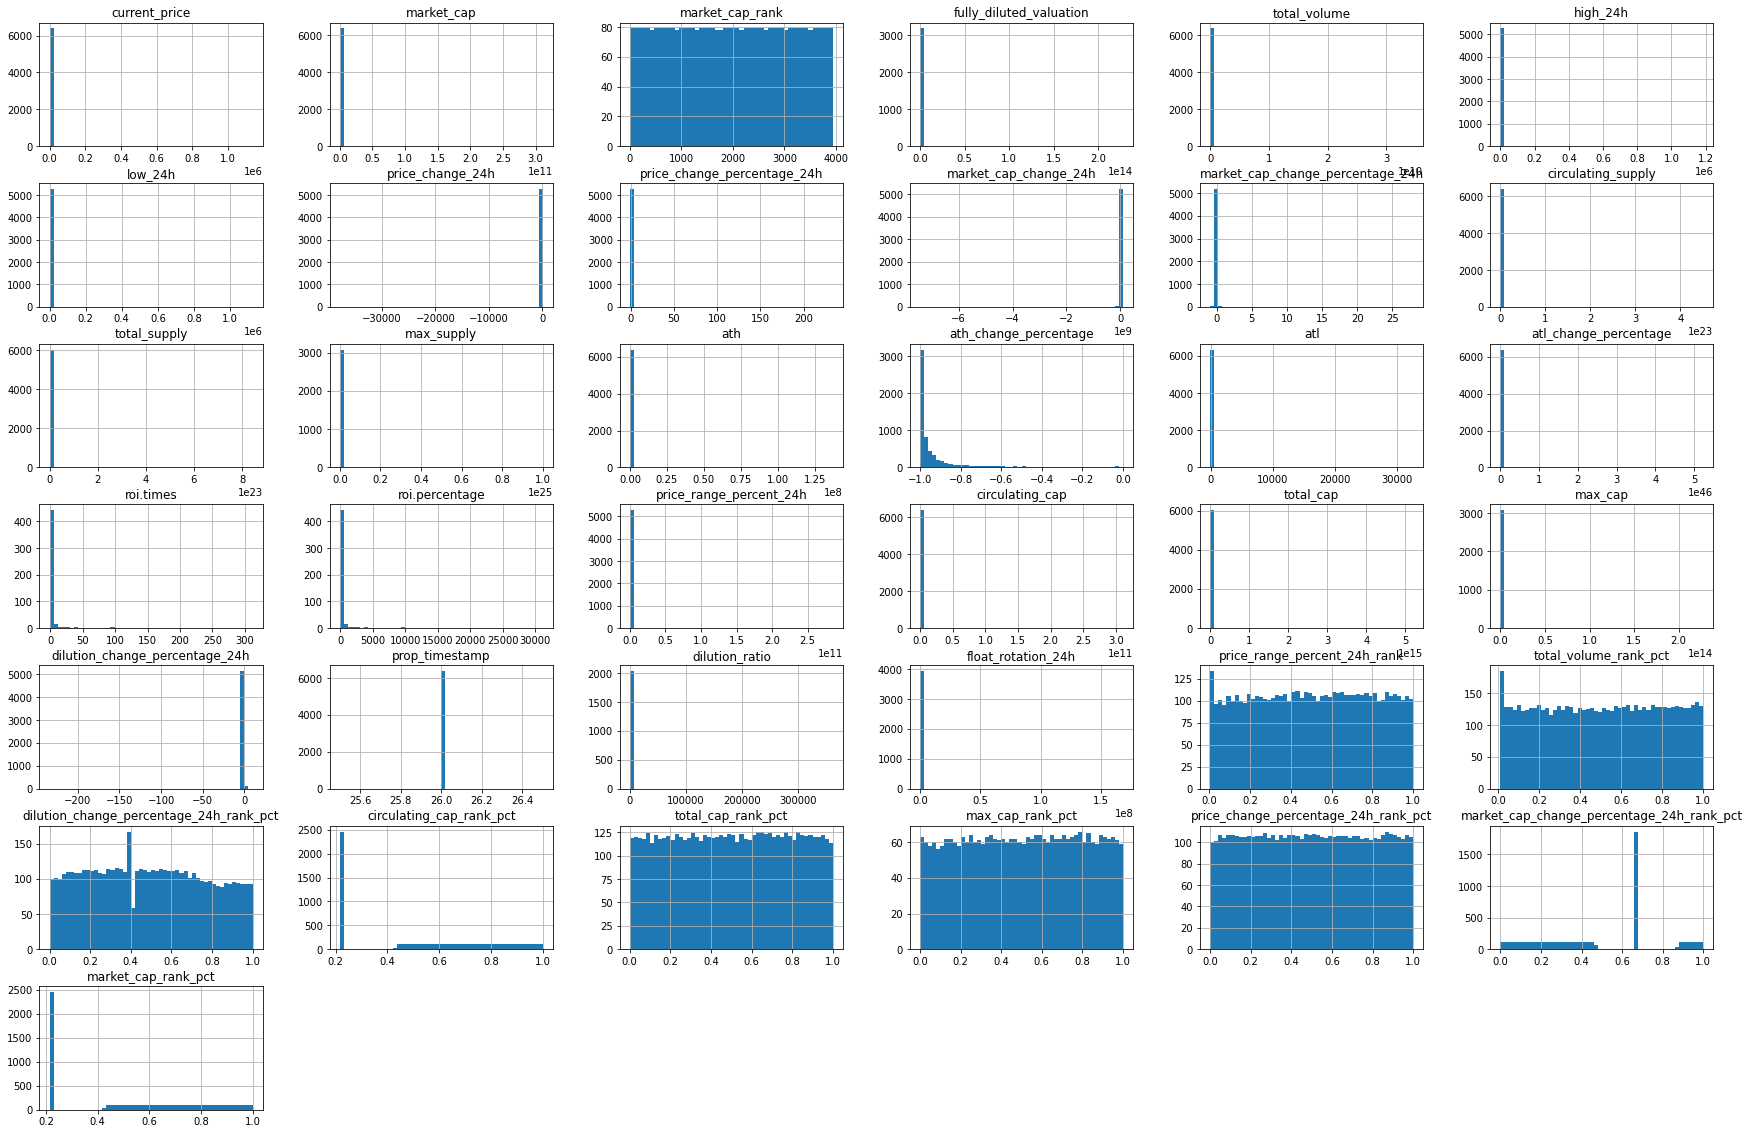

In [50]:

proprietary_screener = "proprietary_screener"

full_table.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

main = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

main.head()
main.hist(bins = 50,figsize = (30, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effa0779a50>,
      dtype=object)

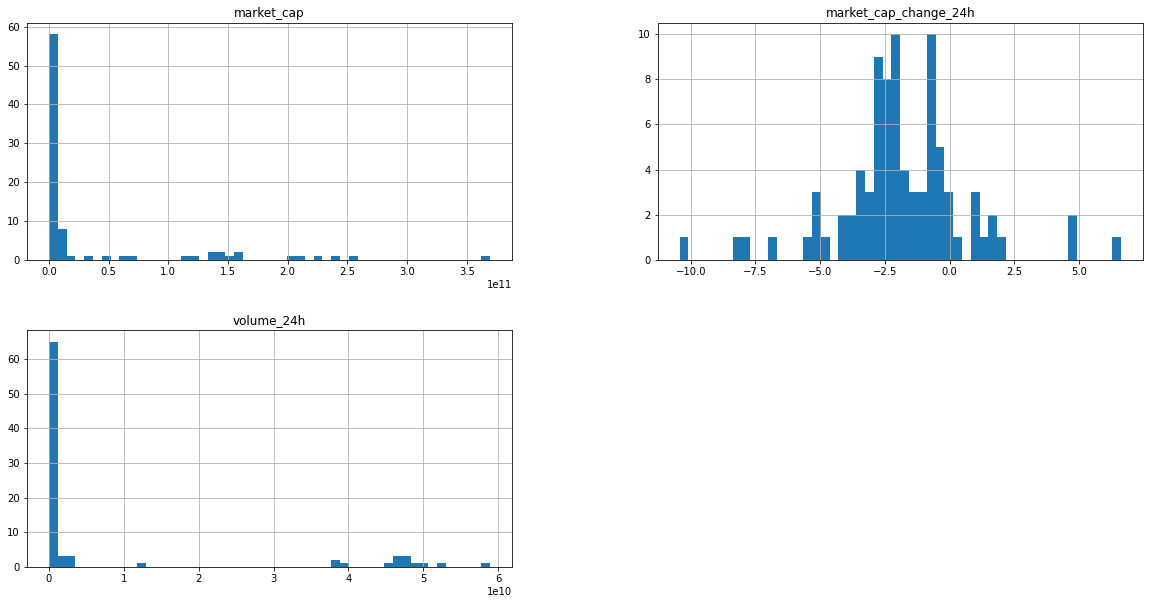

In [51]:
#@title Categories Data { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_coins_categories(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)
del data['top_3_coins']

CoinGecko_derivatives = "CoinGecko_categories"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 
Order by market_cap_change_24h	
""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.hist(bins = 50,figsize = (20, 10))





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff9fe0a5d0>,
      dtype=object)

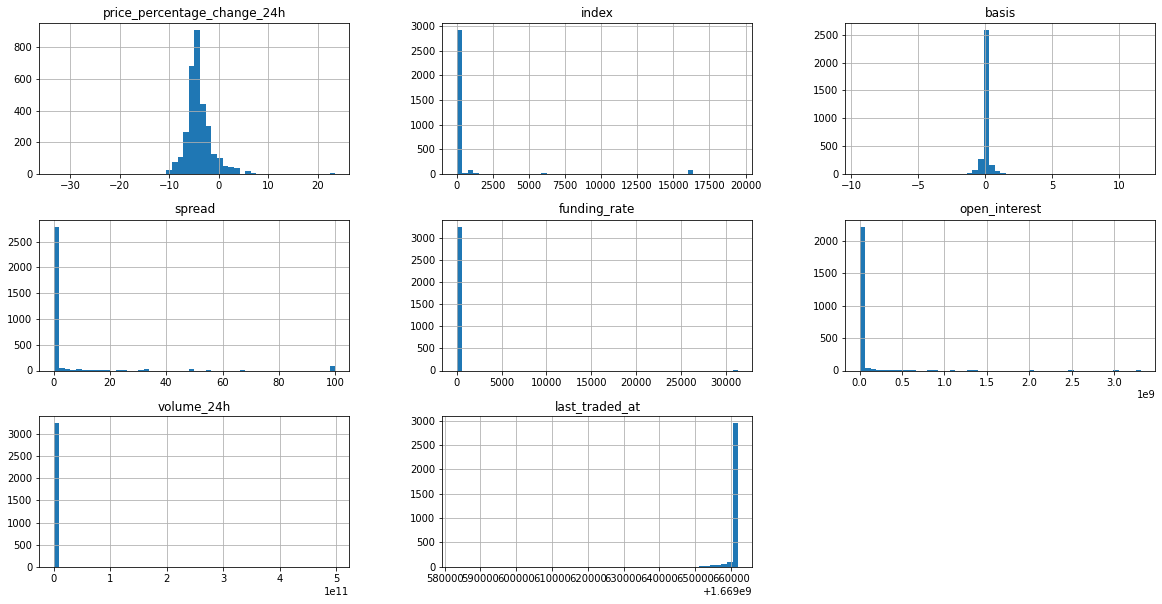

In [52]:
#@title Futures Product { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_derivatives(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output, columns =(
    ['market', 'symbol', 'index_id', 'price', 'price_percentage_change_24h',
       'contract_type', 'index', 'basis', 'spread', 'funding_rate',
       'open_interest', 'volume_24h', 'last_traded_at', 'last_traded_at_f']))

data['last_traded_at_f'] = pd.to_datetime(data['last_traded_at'], unit='s')
CoinGecko_derivatives = "CoinGecko_derivatives"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.hist(bins = 50,figsize = (20, 10))




In [53]:
output = cg.get_derivatives_exchanges()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

#@title Futures Exchanges { display-mode: "code" }

CoinGecko_derivatives = "CoinGecko_derivatives_exchange_list"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)
CoinGecko_derivatives.head()


name               id  open_interest_btc trade_volume_24h_btc  \
0  Binance (Futures)  binance_futures          430988.44           2394390.04   
1    BingX (Futures)    bingx_futures          304648.73            401686.72   
2    BTCEX (Futures)    btcex_futures          261070.02            772324.77   
3     Bitget Futures   bitget_futures          233464.66            413203.67   
4       BTCC Futures     btcc_futures          230183.92            588012.78   

   number_of_perpetual_pairs  number_of_futures_pairs  \
0                        237                       42   
1                        155                        0   
2                         84                        0   
3                        108                        0   
4                         11                       63   

                                               image  year_established  \
0  https://assets.coingecko.com/markets/images/46...            2019.0   
1  https://assets.coingecko.com/markets/images/91...               NaN   
2  https://assets.coingecko.com/markets/images/75...               NaN   
3  https://assets.coingecko.com/markets/images/59...               NaN   
4  https://assets.coingecko.com/markets/images/84...            2011.0   

  country                                        description  \
0    None                                                      
1    None  Founded in 2018, BingX is a crypto social trad...   
2    None                                                      
3    None                                                      
4    None                                                      

                                 url  
0           https://www.binance.com/  
1                 https://bingx.com/  
2       https://www.btcex.com/en-us/  
3         https://www.bitget.com/en/  
4  https://www.btcc.com/en-US/trade/


Reusable scripts

Short
```
WHERE
market_cap > 100000000
AND
dilution_ratio > 6;
```
Long
```
WHERE
price_change_percentage_24h > '2.0e-01'
AND
float_rotation_24h >  0.2
AN
dilution_ratio <  5
```

In [54]:
#@title OHLC { display-mode: "code" }


proprietary_master_id  = "proprietary_screener"

base = pd.read_sql(
"""
SELECT
id,
market_cap,
price_change_percentage_24h,
float_rotation_24h,
dilution_ratio

FROM {}

WHERE
price_change_percentage_24h > 0.25

;
""".format(proprietary_master_id), conn_SQLite)

base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           109 non-null    object 
 1   market_cap                   109 non-null    float64
 2   price_change_percentage_24h  109 non-null    float64
 3   float_rotation_24h           53 non-null     float64
 4   dilution_ratio               17 non-null     float64
dtypes: float64(4), object(1)
memory usage: 4.4+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effa0970590>,
      dtype=object)

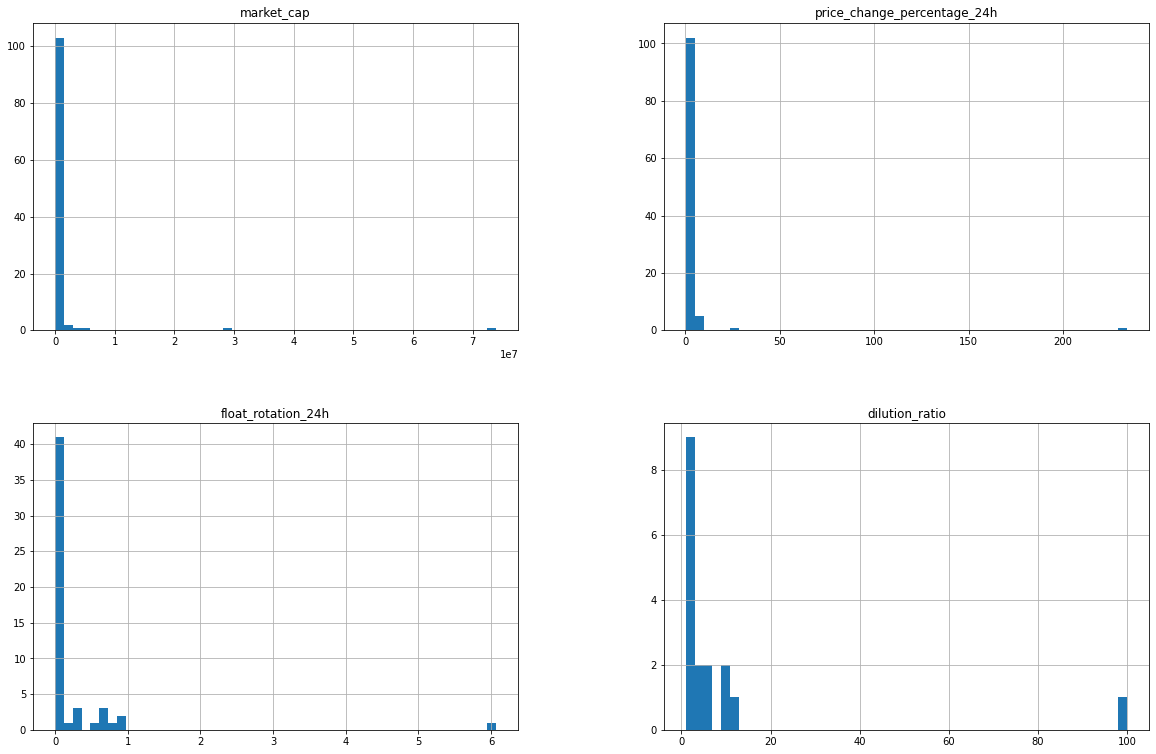

In [55]:
base.hist(bins = 50,figsize = (20,13))

In [56]:
from talib.abstract import *

cg = CoinGeckoAPI()
CoinGecko_id = base['id']
frames = []

try:

  start = 0
  ends = len(CoinGecko_id)
  
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_ohlc_by_id(id=i, vs_currency='usd', days = 'max')

    df = pd.DataFrame(data=a, columns = ['date','open','high', 'low', 'close'])

    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    df['id'] = str(i)
    df['sma10'] = SMA(df, timeperiod=10,price='close') # calculate on close prices by default
    df['sma20'] = SMA(df, timeperiod=20,price='close') # calculate on close prices by default
    df['sma50'] = SMA(df, timeperiod=50,price='close') # calculate on close prices by default
    df['sma100'] = SMA(df, timeperiod=100,price='close') # calculate on close prices by default
    df['sma200'] = SMA(df, timeperiod=200,price='close') # calculate on close prices by default
    df['atr'] = ATR(df, timeperiod=20) # calculate on close prices by default

    trace1 = {
    'x': df.datetime,
    'open': df.open,
    'close': df.close,
    'high': df.high,
    'low': df.low,
    'type': 'candlestick',
    'name': str(i).upper(),
    'showlegend': True
    }


    trace2 = {
        'x': df.datetime,
        'y': df.sma10,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'yellow'
                },
        'name': 'SMA 10'
    }

    trace3 = {
        'x': df.datetime,
        'y': df.sma20,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'orange'
        },
        'name': 'SMA 20'
    }
    trace4 = {
        'x': df.datetime,
        'y': df.sma50,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'green'
                },
        'name': 'SMA 50'
    }

    trace5 = {
        'x': df.datetime,
        'y': df.sma100,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'blue'
        },
        'name': 'SMA 100'
    }
    trace6 = {
        'x': df.datetime,
        'y': df.sma200,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'purple'
        },
        'name': 'SMA 200'
    }

    data = [trace1, trace2, trace3,trace4,trace5,trace6]

    # Config graph layout
    layout = go.Layout({
        'title': {
            'text': str(i).upper().replace("-"," ") + ' Moving Averages',
            'font': {
                'size': 15
            }
        }
    })

              
      #CHARTING
    fig = go.Figure(data=data, layout=layout)
    fig.show()


    CoinGeckoAPI
    #time.sleep(60/50)
    frames.append(df)
    

except ConnectionError:
  time.sleep(60)

single = pd.concat(frames) #Careful, this line must be outside of the for loop
single['prop_timestamp'] = int( time.time_ns() / 1000 )

single['query_date'] = date.today()
fig.write_html("Moving Averages.html")

  0%|          | 0/109 [00:00<?, ?it/s]

In [57]:
single.tail()


date      open      high       low     close   datetime  \
256  1668470400000  0.005564  0.007097  0.005564  0.005812 2022-11-15   
257  1668816000000  0.005003  0.005005  0.004999  0.004999 2022-11-19   
258  1669161600000  0.004778  0.004778  0.004512  0.004524 2022-11-23   
259  1669507200000  0.004714  0.004773  0.004681  0.004752 2022-11-27   
260  1669766400000  0.004780  0.004780  0.004780  0.004780 2022-11-30   

           id     sma10     sma20     sma50    sma100    sma200       atr  \
256  sonocoin  0.007313  0.010516  0.009831  0.019864  0.034617  0.003383   
257  sonocoin  0.006882  0.009716  0.009827  0.019414  0.034572  0.003255   
258  sonocoin  0.006558  0.009030  0.009847  0.018950  0.034550  0.003116   
259  sonocoin  0.006294  0.008314  0.009577  0.018479  0.034534  0.002973   
260  sonocoin  0.005984  0.007598  0.009338  0.018097  0.034518  0.002826   

       prop_timestamp  query_date  
256  1669662519284584  2022-11-28  
257  1669662519284584  2022-11-28  
258  1669662519284584  2022-11-28  
259  1669662519284584  2022-11-28  
260  1669662519284584  2022-11-28

In [58]:
proprietary_screener = "proprietary_screener_ohlc"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

ohlc = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

ohlc

date      open      high       low     close  \
0   1669766400000  0.000013  0.000013  0.000013  0.000013   
1   1669766400000  0.000017  0.000017  0.000017  0.000017   
2   1669507200000  0.000662  0.000662  0.000616  0.000616   
3   1669766400000  0.000011  0.000011  0.000011  0.000011   
4   1669766400000  0.000871  0.000871  0.000871  0.000871   
..            ...       ...       ...       ...       ...   
94  1669766400000  0.000930  0.000930  0.000930  0.000930   
95  1669766400000  0.002602  0.002602  0.002602  0.002602   
96  1669766400000  0.000501  0.000501  0.000501  0.000501   
97  1669766400000  0.003494  0.003494  0.003494  0.003494   
98  1669766400000  0.001093  0.001093  0.001093  0.001093   

               datetime             id     sma10     sma20     sma50  \
0   2022-11-30 00:00:00           1337  0.000019  0.000014  0.000015   
1   2022-11-30 00:00:00          aeron  0.000020  0.000021  0.000030   
2   2022-11-27 00:00:00        agrello  0.000607  0.000670  0.000861   
3   2022-11-30 00:00:00   ailink-token  0.000018  0.000020  0.000020   
4   2022-11-30 00:00:00       atheneum  0.000957  0.000963  0.001104   
..                  ...            ...       ...       ...       ...   
94  2022-11-30 00:00:00      zenc-coin  0.008157  0.008844  0.007634   
95  2022-11-30 00:00:00        zennies  0.002545  0.001287  0.000540   
96  2022-11-30 00:00:00  zero-exchange  0.000836  0.000844  0.000945   
97  2022-11-30 00:00:00      zik-token  0.004128  0.003508  0.006425   
98  2022-11-30 00:00:00         zodium  0.001129  0.001757  0.005753   

      sma100    sma200       atr    prop_timestamp  query_date  
0   0.000021  0.000036  0.000018  1669662519284584  2022-11-28  
1   0.000072  0.004199  0.000048  1669662519284584  2022-11-28  
2   0.001934  0.049436  0.000294  1669662519284584  2022-11-28  
3   0.000033  0.000040  0.000005  1669662519284584  2022-11-28  
4   0.003061  0.004937  0.000620  1669662519284584  2022-11-28  
..       ...       ...       ...               ...         ...  
94       NaN       NaN  0.002059  1669662519284584  2022-11-28  
95  0.000392       NaN  0.000571  1669662519284584  2022-11-28  
96  0.002324       NaN  0.000384  1669662519284584  2022-11-28  
97  0.008290  0.005046  0.003444  1669662519284584  2022-11-28  
98       NaN       NaN  0.004088  1669662519284584  2022-11-28  

[99 rows x 15 columns]

In [ ]:
#@title Other Historical { display-mode: "code" }
from talib.abstract import *
import pandas as pd
import numpy as np

cg = CoinGeckoAPI()
CoinGecko_id = base['id']
frames = []


try:
  start = 0
  ends = len(CoinGecko_id)
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_market_chart_by_id(id=i, vs_currency='usd', days = 'max')

    b = a['prices']
    df1 = pd.DataFrame(b, columns = ['date','price'])
    df1['datetime'] = pd.to_datetime(df1['date'], unit='ms')
    df1.set_index("date", inplace = True)

    c = a['market_caps']
    df2 = pd.DataFrame(c, columns = ['date','market_cap'])
    df2.set_index("date", inplace = True)

    d = a['total_volumes']
    df3 = pd.DataFrame(d, columns = ['date','volume'])   
    df3.set_index("date", inplace = True)

    result = pd.concat([df1, df2,df3], ignore_index=False,axis=1)

    result['id'] = i
    result['stdev_30d'] = result['price'].rolling(30).std()
    result['volume_30d'] = result['volume'].rolling(30).mean()
    result['rel_volume'] = result['volume'] / result['volume_30d'] 
    result['float_rotation'] = result['volume'] / result['market_cap'] 
    

    frames.append(result)
    time.sleep(60/50)
except ConnectionError:
    time.sleep(60)
single = pd.concat(frames) #Careful, this line must be outside of the for loop



single.tail()

  0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:
from numpy.lib.twodim_base import histogram2d

proprietary_screener = "proprietary_screener_hist"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=True) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost. WHERE datetime CONTAINS '2021'

hist = pd.read_sql("""
select 
*
from {}  

Group by id


""".format(proprietary_screener), conn_SQLite)

hist.hist(bins = 50,figsize = (20, 10))

In [ ]:
#df =  base.join(ohlc)

df1 = base.merge(hist, on='id', how='left')
df2 = df1.merge(ohlc, on='id', how='right')
df2

In [ ]:
#base.set_index("id", inplace = True)
#ohlc.set_index("id", inplace = True)
#hist.set_index("id", inplace = True)

frames = [base,ohlc, hist]

#result = pd.concat(frames)
result = pd.merge(frames, how="left", left_on='id', right_on='id')

result

Get CoinGecko Market Data

# Futures Coverage Indicator

In [ ]:
#Query the derivatives table

# Group table By index ID and create a: where if the  contract type includes perpetual, at P Contract type Futures exist, at letter



In [ ]:
proprietary_screener.head()

In [ ]:
proprietary_screener.info()

In [ ]:
#@title Gets Currencies { display-mode: "code" }
output = cg.get_supported_vs_currencies()
data = pd.DataFrame(output, columns =['currencies'])
CoinGecko_currencies = "CoinGecko_currencies"



data.to_sql(CoinGecko_currencies, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_currencies = pd.read_sql('select * from {}'.format(CoinGecko_currencies), conn_SQLite)

In [ ]:
#@title
output = cg.get_derivatives()
data = pd.json_normalize(output,max_level=4)
data.hist(bins = 50,figsize = (20, 10))

In [ ]:
#@title Get Global Data { display-mode: "code" }

output = cg.get_global()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

CoinGecko_global = "CoinGecko_global"

data.to_sql(CoinGecko_global, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_global = pd.read_sql('select * from {}'.format(CoinGecko_global), conn_SQLite)
CoinGecko_global.info()

In [ ]:
#@title Get Assess platforms { display-mode: "code" }

output = cg.get_asset_platforms()

data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)



CoinGecko_asset_platforms = "CoinGecko_asset_platforms"

data.to_sql(CoinGecko_asset_platforms, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_asset_platforms = pd.read_sql('select * from {}'.format(CoinGecko_asset_platforms), conn_SQLite)
CoinGecko_asset_platforms.info()

**bold text**# Create Features

In [ ]:
#@title
# Just be sure any changes have been committed or they will be lost.
conn_SQLite.close()

# Backtesting

# Chartbook
